# Exploration 11
# Classification on X-rays

## 프로젝트 : 폐렴 진단기 성능개선
### |프로젝트 학습 과정

1. 실험환경 Set-up
    - 사용할 데이터: [Chest X-Ray Images (Pneumonia)](https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia)
2. 데이터 준비하기
3. 데이터 시각화
4. CNN 모델링
5. 데이터 imbalance 처리
6. 모델 훈련
7. 결과 확인과 시각화

### |프로젝트 평가
| |평가문항|상세기준|
|------|---|---|
|1|의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.|모델 학습이 안정적으로 수렴하는 것을 시각화를 통해 확인하였다.|
|2|데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.|regularization, augmentation 등의 기법의 사용 여부에 따른 모델 성능 측정이 ablation study 형태로 체계적으로 수행되었다.|
|3| 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.|Accuracy 기준 85%에 도달하였다.|

참고: https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays

## 이미지 분류 목표

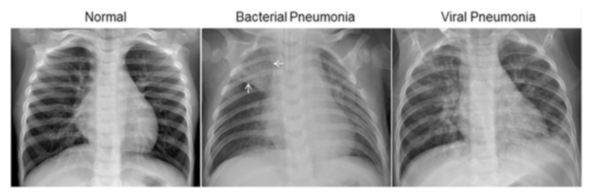

정상 흉부 X-ray는 이미지에서 깨끗한 폐를 보여주고 있고, 가운데 세균성 폐렴은 우상엽에서 흐릿한 부분이 있다. 오른쪽 이미지는 바이러스성 폐렴에 걸린 모습으로 양쪽 폐에 더 확산된 모습이다.

## Data info

Dataset은 train, test, val로 구성되며 각 이미지 범주 Pneumonia/Normal 에 대한 하위 폴더를 포함합니다. 5,863개의 이미지(JPEG)와 2개의 class (폐렴/정상)가 있습니다.

### 분류해야 할 Class
- Normal : 정상
- Pneumonia : 폐렴

# 1. 실험환경 Set-up

### Importing Libraries

In [24]:
import tensorflow as tf

import re
import os
import random, math
import pandas as pd
import numpy as np
import itertools
import PIL

from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D#, BatchNormalization
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras.callbacks import ReduceLROnPlateau # use this class when a metric has stopped improving https://keras.io/api/callbacks/reduce_lr_on_plateau/
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical

from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

from keras.datasets import mnist

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [25]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

Number of replicas: 1
2.4.1


In [26]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*'
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

print(ROOT_PATH)

/aiffel/aiffel


### Dfining Hyperparameters

In [27]:
BATCH_SIZE = 16
EPOCHS = 25

# 2. 데이터 준비하기

In [8]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [3]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [4]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/NORMAL2-IM-0627-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person569_bacteria_2360.jpeg


In [5]:
# 이제 파일 경로에 NORMAL이 있는지 확인하면 정상 이미지를 셀 수 있습니다.
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")

# 파일 경로에 PNEUMONIA이 있는지 확인하면 폐렴 이미지도 셀 수 있습니다.
COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [8]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [12]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [13]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

# 3. 데이터 시각화

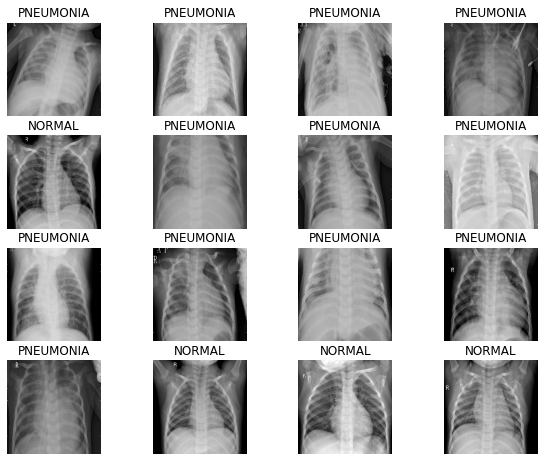

In [14]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(5,math.ceil(BATCH_SIZE/5),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

# 4. CNN 모델링

In [15]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [16]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [17]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# 5. 데이터 imbalance 처리

In [18]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


# 6. 모델 훈련

In [19]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [20]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 55s 141ms/step - loss: 0.5660 - accuracy: 0.6974 - precision: 0.9045 - recall: 0.6637 - val_loss: 0.6346 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 35s 133ms/step - loss: 0.2661 - accuracy: 0.8882 - precision: 0.9667 - recall: 0.8824 - val_loss: 1.3004 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 35s 134ms/step - loss: 0.2458 - accuracy: 0.9050 - precision: 0.9748 - recall: 0.8978 - val_loss: 0.1766 - val_accuracy: 0.9279 - val_precision: 0.9128 - val_recall: 0.9974
Epoch 4/25
261/261 [==============================] - 35s 135ms/step - loss: 0.2015 - accuracy: 0.9188 - precision: 0.9751 - recall: 0.9147 - val_loss: 0.0924 - val_accuracy: 0.9663 - val_precision: 0.9880 - val_recall: 0.9660
Epoch 5/25
261/261 [==============================] - 35s 135ms/step - loss: 0.1852 - accura

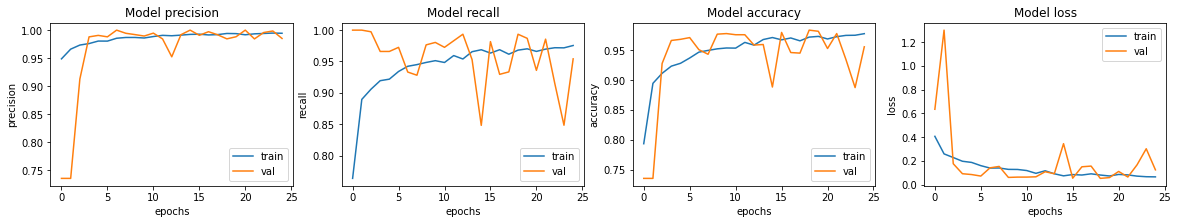

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 1.1431 - accuracy: 0.7756 - precision: 0.7432 - recall: 0.9795
Loss: 1.1431337594985962,
Accuracy: 0.7756410241127014,
Precision: 0.7431906461715698,
Recall: 0.9794871807098389


Recall 값은 0.97로 매우 높은데, accuracy는 0.77로 낮은 편이네요. 실제 폐렴 환자를 판단하기 위해 Recall 값이 가장 중요하다고 볼 수 있지만, accuracy를 더 올릴 필요가 있어 보입니다!

지금부터 accuracy를 높이기 위해 시도를 해보겠습니다.

# Building Model 1

In [72]:
BATCH_SIZE = 16
EPOCHS = 15

In [73]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [ ]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

In [74]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [75]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/15
261/261 [==============================] - 80s 249ms/step - loss: 0.6169 - accuracy: 0.6855 - precision: 0.8833 - recall: 0.6620 - val_loss: 0.6738 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 64s 247ms/step - loss: 0.2508 - accuracy: 0.8951 - precision: 0.9672 - recall: 0.8898 - val_loss: 1.5338 - val_accuracy: 0.7365 - val_precision: 0.7365 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 65s 249ms/step - loss: 0.2096 - accuracy: 0.9175 - precision: 0.9718 - recall: 0.9159 - val_loss: 0.1282 - val_accuracy: 0.9442 - val_precision: 0.9380 - val_recall: 0.9895
Epoch 4/15
261/261 [==============================] - 65s 250ms/step - loss: 0.1950 - accuracy: 0.9225 - precision: 0.9710 - recall: 0.9230 - val_loss: 0.2859 - val_accuracy: 0.9154 - val_precision: 0.9971 - val_recall: 0.8879
Epoch 5/15
261/261 [==============================] - 65s 250ms/step - loss: 0.1794 - accura

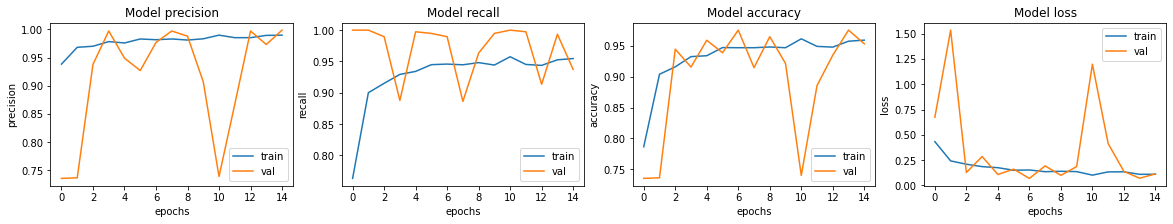

In [76]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [77]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 77ms/step - loss: 0.4367 - accuracy: 0.8542 - precision: 0.8300 - recall: 0.9641
Loss: 0.43674957752227783,
Accuracy: 0.8541666865348816,
Precision: 0.8300220966339111,
Recall: 0.964102566242218


epoch를 15로 낮추고 Conv layer를 128, 64로 늘려주니 accuracy가 많이 올랐습니다.

모델을 튜닝하며 다 저장해두진 않았지만 0.79에서 0.72, 0.65, 0.63, 0.62까지 내려가다가 무엇이 문제지? 하고 Convolution layer 수를 조정해주니 accuracy는 목표 수치까지 달성했습니다. 폐렴 진단 여부이기 때문에 중요한 지표가 되는 recall도 0.96으로 나쁘지 않은 수치가 나온 것 같습니다.

하지만 그래프로 train 과 val의 성능을 지켜보았을 땐, 매우 안 좋다는 것이 한눈에 보이네요. 어떤 식으로 튜닝하고 잡아야 정상적인 그래프가 나올까요?

# # Building Model 2

In [78]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [89]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )



es = EarlyStopping(monitor='val_loss', mode='min', patience=2, verbose=1)


with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
callbacks=[es]
    )

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67
Epoch 1/15
261/261 [==============================] - 72s 247ms/step - loss: 0.4536 - accuracy: 0.7620 - precision: 0.9335 - recall: 0.7300 - val_loss: 0.8400 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/15
261/261 [==============================] - 65s 247ms/step - loss: 0.2096 - accuracy: 0.9165 - precision: 0.9796 - recall: 0.9065 - val_loss: 1.4508 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 3/15
261/261 [==============================] - 65s 247ms/step - loss: 0.2134 - accuracy: 0.9231 - precision: 0.9777 - recall: 0.9189 - val_loss: 0.1139 - val_accuracy: 0.9615 - val_precision: 0.9607 - val_recall: 0.9883
Epoch 4/15
261/261 [==============================] - 65s 249ms/step - loss: 0.1757 - accuracy: 0.9338 - precision: 0.9797 - recall: 0.9307 - val_loss: 0.0696 - val_accuracy: 0.9788 - val_precision: 0.9856 - val_recall: 0.9856
Epoch 5/15
261/261 [=====================

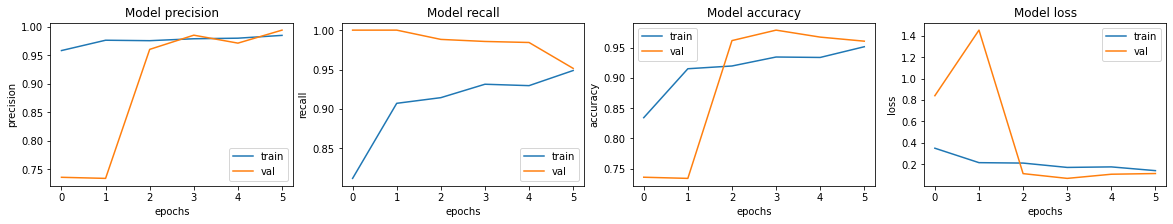

In [90]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [91]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 3s 75ms/step - loss: 0.3488 - accuracy: 0.8590 - precision: 0.8283 - recall: 0.9769
Loss: 0.3487909138202667,
Accuracy: 0.8589743375778198,
Precision: 0.8282608985900879,
Recall: 0.9769230484962463


# 프로젝트 정리

### 1. baseline
recall: 0.9795   
Loss: 1.1431337594985962,   
Accuracy: 0.7756410241127014,   
Precision: 0.7431906461715698,   
Recall: 0.9794871807098389   

### 2. Model Building 1
recall: 0.9641   
Loss: 0.43674957752227783,   
Accuracy: 0.8541666865348816,   
Precision: 0.8300220966339111,   
Recall: 0.964102566242218   

### 3. Model Building 2
recall: 0.9769   
Loss: 0.3487909138202667,   
Accuracy: 0.8589743375778198,   
Precision: 0.8282608985900879,   
Recall: 0.9769230484962463   

Model Building 2는 earlystopping callback을 추가해주었고, Conv2D layer 수를 256,128 로 늘려주었다. 정확도는 비슷하지만 recall이 올라가고 Loss 가 많이 떨어졌다. 이전보다 그래프도 더 평이한 모습으로 바뀌었다.

## 소감
이미지 분류를 위한 Sequential의 CNN model을 한 번도 안 해보았던 것도 아니고 이미지 분류도 여러 번 해보았는데, 이번 프로젝트도 막막했던 이유는 개념과 이론 등이 부족하고 이해도가 떨어진다는 걸 다시 한 번 더 절실히 느꼈습니다. 이전에 했던 EX 프로젝트를 복습해보거나, keras, deeplearning, tf master 수업 등을 복습할 필요가 있을 것 같습니다!